In [1]:
from edgedroid.models.timings import *

runs_per_model = 30
task_steps = 100

models = {
    "empirical": {
        "low": EmpiricalExecutionTimeModel.from_default_data(neuroticism=0.0),
        "high": EmpiricalExecutionTimeModel.from_default_data(neuroticism=1.0),
    },
    "theoretical": {
        "low": TheoreticalExecutionTimeModel.from_default_data(neuroticism=0.0),
        "high": TheoreticalExecutionTimeModel.from_default_data(neuroticism=1.0),
    },
    "constant": {"n/a": ConstantExecutionTimeModel.from_default_data()},
    "naive": {"n/a": NaiveExecutionTimeModel.from_default_data()},
    "fitted-naive": {"n/a": FittedNaiveExecutionTimeModel.from_default_data()},
}

In [2]:
import numpy as np

ttfs = np.linspace(0, 5, 25)
ttfs

array([0.        , 0.20833333, 0.41666667, 0.625     , 0.83333333,
       1.04166667, 1.25      , 1.45833333, 1.66666667, 1.875     ,
       2.08333333, 2.29166667, 2.5       , 2.70833333, 2.91666667,
       3.125     , 3.33333333, 3.54166667, 3.75      , 3.95833333,
       4.16666667, 4.375     , 4.58333333, 4.79166667, 5.        ])

In [3]:
import pandas as pd
import itertools as it

combs = deque()
for model_name, variants in models.items():
    for neuro, model in variants.items():
        for ttf, run in it.product(ttfs, range(1, runs_per_model + 1)):
            combs.append((model, model_name, neuro, ttf, run))

# results = pd.DataFrame(
#     columns=["model", "neuroticism", "repetition", "step", "exec_time", "ttf", "duration", "cumulative_duration"],
#     index=np.arange(0, len(combs))
# )
# results["model"] = "fitted-naive"
# results["neuroticism"] = "n/a"
# results["repetition"]  = -1
# results["step"] = -1
# results["exec_time"] = 0.0
# results["ttf"] = 0.0
# results["duration"] = 0.0
# results["cumulative_duration"] = 0.0
#
# results["model"] = results["model"].astype(pd.CategoricalDtype(models.keys(), ordered=False))
# results["neuroticism"] = results["neuroticism"].astype(pd.CategoricalDtype(["n/a", "low", "high"], ordered=True))
# results["repetition"] = results["repetition"].astype(int)
# results["step"] = results["step"].astype(int)
# results["exec_time"] = results["exec_time"].astype(float)
# results["ttf"] = results["ttf"].astype(float)
# results["duration"] = results["duration"].astype(float)
# results["cumulative_duration"] = results["cumulative_duration"].astype(float)
#
# results.shape

In [4]:
from tqdm.notebook import tqdm_notebook as tqdm

curr_idx = 0
tqdm_iter = tqdm(combs)

rows = deque()

for model, model_name, neuro, ttf, repetition in tqdm_iter:
    tqdm_iter.set_description(
        desc=f"Model {model_name}, neuro {neuro}, TTF {ttf:0.02f}s, repetition {repetition}"
    )
    model.reset()
    cum_duration = 0.0

    for step in range(1, task_steps + 1):
        exec_time = model.advance(ttf).get_execution_time()
        duration = exec_time + ttf
        cum_duration += duration

        rows.append(
            {
                "model": model_name,
                "neuroticism": neuro,
                "repetition": repetition,
                "step": step,
                "exec_time": exec_time,
                "ttf": ttf,
                "duration": duration,
                "cumulative_duration": cum_duration,
            }
        )

        # results.loc[curr_idx, ["model", "neuroticism", "repetition", "step", "exec_time", "ttf", "duration", "cumulative_duration"]] = \
        #     [model_name, neuro, repetition, step, exec_time, ttf, duration, cum_duration]


        # model_name
        # results.at[curr_idx, "neuroticism"] = neuro
        # results.at[curr_idx, "repetition"] = repetition
        # results.at[curr_idx, "step"] = step
        # results.at[curr_idx, "exec_time"] = exec_time
        # results.at[curr_idx, "ttf"] = ttf
        # results.at[curr_idx, "duration"] = duration
        # results.at[curr_idx, "cumulative_duration"] = cum_duration

        curr_idx += 1

results = pd.DataFrame(rows)
results["model"] = results["model"].astype(pd.CategoricalDtype(models.keys(), ordered=False))
results["neuroticism"] = results["neuroticism"].astype(pd.CategoricalDtype(["n/a", "low", "high"], ordered=True))
results["repetition"] = results["repetition"].astype(int)
results["step"] = results["step"].astype(int)
results["exec_time"] = results["exec_time"].astype(float)
results["ttf"] = results["ttf"].astype(float)
results["duration"] = results["duration"].astype(float)
results["cumulative_duration"] = results["cumulative_duration"].astype(float)
results

  0%|          | 0/5250 [00:00<?, ?it/s]

,model,neuroticism,repetition,step,exec_time,ttf,duration,cumulative_duration
0,empirical,low,1,1,5.655492,0.0,5.655492,5.655492
1,empirical,low,1,2,7.798761,0.0,7.798761,13.454253
2,empirical,low,1,3,2.272532,0.0,2.272532,15.726785
3,empirical,low,1,4,3.436899,0.0,3.436899,19.163684
4,empirical,low,1,5,6.466178,0.0,6.466178,25.629862
...,...,...,...,...,...,...,...,...
524995,fitted-naive,n/a,30,96,4.372006,5.0,9.372006,1048.702722
524996,fitted-naive,n/a,30,97,3.592952,5.0,8.592952,1057.295674
524997,fitted-naive,n/a,30,98,3.505438,5.0,8.505438,1065.801112
524998,fitted-naive,n/a,30,99,3.865695,5.0,8.865695,1074.666807


In [33]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("Dark2")

end_steps = results[results.step == results.step.max()].copy()
end_steps["reference"] = False
end_steps.loc[end_steps["neuroticism"] == "n/a", "reference"] = True
end_steps

,model,neuroticism,repetition,step,exec_time,ttf,duration,cumulative_duration,reference
99,empirical,low,1,100,8.154765,0.0,8.154765,499.679922,False
199,empirical,low,2,100,5.835424,0.0,5.835424,520.923305,False
299,empirical,low,3,100,2.968007,0.0,2.968007,521.031186,False
399,empirical,low,4,100,2.474903,0.0,2.474903,480.242019,False
499,empirical,low,5,100,2.321911,0.0,2.321911,504.955080,False
...,...,...,...,...,...,...,...,...,...
524599,fitted-naive,n/a,26,100,8.457613,5.0,13.457613,1146.332142,True
524699,fitted-naive,n/a,27,100,5.086385,5.0,10.086385,1079.362672,True
524799,fitted-naive,n/a,28,100,9.177785,5.0,14.177785,1083.225966,True
524899,fitted-naive,n/a,29,100,4.525913,5.0,9.525913,1064.668903,True


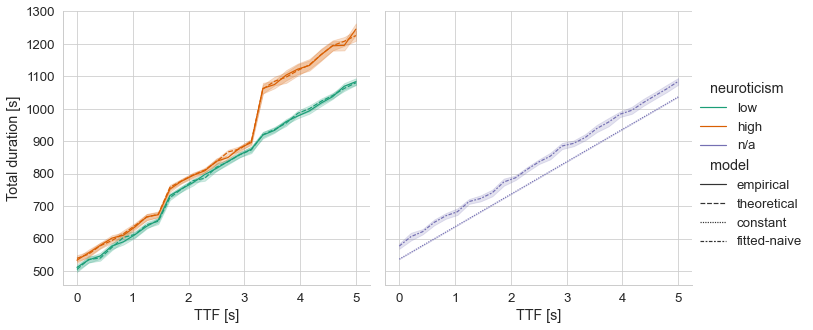

In [143]:
fg = sns.relplot(
    kind="line",
    data=end_steps,
    # err_style="bars",
    x="ttf",
    y="cumulative_duration",
    style="model",
    hue="neuroticism",
    style_order=["empirical", "theoretical", "constant", "fitted-naive",],
    # hue="neuroticism",
    col="reference",
    hue_order=["low", "high", "n/a"],
    # markers=["v", "^", "X"],
    markersize=7,
)
fg.set_axis_labels("TTF [s]", "Total duration [s]")
fg.set_titles("", "")
# fg.set(yscale="log")
plt.show()

In [68]:
max_durations = end_steps[end_steps.ttf == end_steps.ttf.max()].groupby(["model", "neuroticism"], observed=True)["cumulative_duration"].mean()
(max_durations - max_durations[("fitted-naive", "n/a")])/max_durations[("fitted-naive", "n/a")]

model         neuroticism
empirical     low           -0.001071
              high           0.148352
theoretical   low           -0.004057
              high           0.130114
constant      n/a           -0.044220
naive         n/a            0.000942
fitted-naive  n/a            0.000000
Name: cumulative_duration, dtype: float64

In [69]:
min_durations = end_steps[end_steps.ttf == end_steps.ttf.min()].groupby(["model", "neuroticism"], observed=True)["cumulative_duration"].mean()
(min_durations - min_durations[("fitted-naive", "n/a")])/min_durations[("fitted-naive", "n/a")]

model         neuroticism
empirical     low           -0.113668
              high          -0.075336
theoretical   low           -0.124855
              high          -0.065440
constant      n/a           -0.069587
naive         n/a            0.013525
fitted-naive  n/a            0.000000
Name: cumulative_duration, dtype: float64

In [145]:
ix = pd.IndexSlice

duration_table = end_steps[(end_steps.ttf == end_steps.ttf.max()) | (end_steps.ttf == end_steps.ttf.min())][["model", "neuroticism", "ttf", "cumulative_duration"]]
duration_table = duration_table.groupby(["model", "neuroticism", "ttf"], observed=True).mean()
duration_table["diff"] = 0.0

def get_diff(s: pd.Series) -> pd.Series:
    ref = s.droplevel(-1)[("fitted-naive", "n/a")]
    return ((s - ref) / ref) * 100.0


duration_table["diff"] = duration_table.groupby("ttf")["cumulative_duration"].apply(get_diff)
duration_table.index.names = ["Model", "Neuroticism", r"\ac{TTF}"]
duration_table = duration_table.rename(columns={"cumulative_duration": "Total Duration", "diff": "Diff. w.r.t. fitted-naive"}).stack()
print(
    duration_table
    .loc[
        ix[["fitted-naive", "empirical", "theoretical"]], :
    ]
    .unstack(level=-2)
    .unstack(level=-1)
    .style.format(lambda e: r"\SI{" f"{e:.2f}" r"}{\second}")
    .format(lambda e: ("" if e < 0 else "+") + r"\SI{" f"{e:.2f}" r"}{\percent}",  subset=ix[:, ix[:, "Diff. w.r.t. fitted-naive"]])
    .to_latex(siunitx=True, hrules=True, column_format="llrrrr", )
)# duration_table.style.format()
# print(duration_table.unstack(level=-2).unstack(level=-1).style.to_latex(siunitx=True))

\begin{tabular}{llrrrr}
\toprule
{} & {\ac{TTF}} & \multicolumn{2}{r}{0.000000} & \multicolumn{2}{r}{5.000000} \\
{} & {} & {Total Duration} & {Diff. w.r.t. fitted-naive} & {Total Duration} & {Diff. w.r.t. fitted-naive} \\
{Model} & {Neuroticism} & {} & {} & {} & {} \\
\midrule
fitted-naive & n/a & \SI{576.74}{\second} & +\SI{0.00}{\percent} & \SI{1084.57}{\second} & +\SI{0.00}{\percent} \\
\multirow[c]{2}{*}{empirical} & low & \SI{511.18}{\second} & \SI{-11.37}{\percent} & \SI{1083.40}{\second} & \SI{-0.11}{\percent} \\
 & high & \SI{533.29}{\second} & \SI{-7.53}{\percent} & \SI{1245.46}{\second} & +\SI{14.84}{\percent} \\
\multirow[c]{2}{*}{theoretical} & low & \SI{504.73}{\second} & \SI{-12.49}{\percent} & \SI{1080.16}{\second} & \SI{-0.41}{\percent} \\
 & high & \SI{539.00}{\second} & \SI{-6.54}{\percent} & \SI{1225.68}{\second} & +\SI{13.01}{\percent} \\
\bottomrule
\end{tabular}



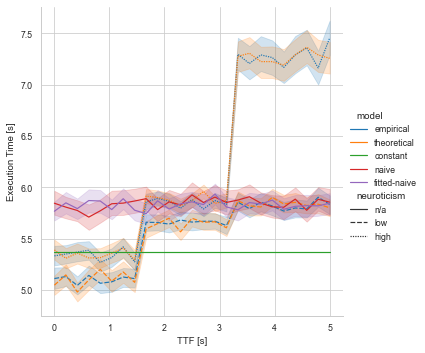

In [7]:
fg = sns.relplot(
    kind="line",
    data=results,
    x="ttf",
    y="exec_time",
    hue="model",
    hue_order=["empirical", "theoretical", "constant", "naive", "fitted-naive"],
    style="neuroticism",
)
fg.set_axis_labels("TTF [s]", "Execution Time [s]")
plt.show()